In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from evaluation import *
import metrics
from sklearn.metrics import roc_auc_score as auc

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
SVC_grid_sarch = {
    'kernel': ['linear',  'sigmoid'],
    'C': [1, 10, 100, 1_000, 10_000, 1_000_000],
    'max_iter': [500_000_00],
    'probability': [True]
}

RF_grid_sarch = {
    'n_estimators': [100, 250, 500, 750],
    'max_depth': [5, 7, 11, None],
    'bootstrap': [False, True],
}

GaussNB_grid_search = {
}

Logr_grid_search = {
    'C': [1, 10, 100, 1000, 1_0000, 100_000, 1_000_000],
    'max_iter': [500_000_000],
    'fit_intercept': [True, False]
}

search_grids = {
    SVC.__name__: SVC_grid_sarch,
    RandomForestClassifier.__name__: RF_grid_sarch,
    GaussianNB.__name__: GaussNB_grid_search,
    LogisticRegression.__name__: Logr_grid_search
}

In [3]:
data = pd.read_csv('./data_preprocess/tran.csv')

models = [
    SVC, 
    RandomForestClassifier, 
    GaussianNB, 
    LogisticRegression
]

models_params = {
    SVC.__name__: {
        'kernel':'linear',
        #'C': 1E6,
        'probability':True
    },
    RandomForestClassifier.__name__: {
        'max_depth': 15,
        'n_estimators':500
    },
    GaussianNB.__name__:{
    },
    LogisticRegression.__name__:{
        'max_iter':10000
    }
}

files_features_selected = {
    'boruta': 'out/features_boruta.txt',
    'forward': 'out/features_forward.txt', 
    'genetic': 'out/features_genetic.txt',
    'lasso': 'out/features_lasso.txt'}

predictions = {}

In [4]:

best_score = 0
best_model = {}
scoring_metric = metrics.balanced_accuracy

for selection_method in files_features_selected:
    with open(files_features_selected[selection_method]) as f:
        features = f.readlines()
        features = [feature.strip() for feature in features]
        
    X = data[features]
    y = data['Positivo']
    
    prediction_models = {}
    for model_obj in models:
        # Busqueda
        search_grid = search_grids[model_obj.__name__]
        Search = GridSearchCV(model_obj(), search_grid, scoring='balanced_accuracy',
                              cv=10, return_train_score=True, verbose=True)
        Search.fit(X, y)
        best_model_params = Search.best_params_
        
        model = model_obj(**best_model_params)
        ytrue, ypred = predict_model_loo(model, X, y, proba=True)
        prediction_models[model_obj.__name__] = {'true':ytrue, 'ypred':ypred}
        
        # Scoring and save best model params
        model_score = scoring_metric(ytrue, ypred)
        if model_score > best_score:
            best_score = model_score
            best_model = {
                'model': model_obj, 
                'model_params': Search.best_params_,
                'features': features
            }
        
        
    
    predictions[selection_method] = prediction_models
    

Fitting 10 folds for each of 12 candidates, totalling 120 fits


110it [26:29, 14.45s/it]


Fitting 10 folds for each of 32 candidates, totalling 320 fits


110it [00:20,  5.46it/s]


Fitting 10 folds for each of 1 candidates, totalling 10 fits


110it [00:00, 1779.35it/s]


Fitting 10 folds for each of 14 candidates, totalling 140 fits


110it [00:34,  3.14it/s]


Fitting 10 folds for each of 12 candidates, totalling 120 fits


110it [00:04, 22.17it/s]


Fitting 10 folds for each of 32 candidates, totalling 320 fits


110it [00:09, 11.37it/s]


Fitting 10 folds for each of 1 candidates, totalling 10 fits


110it [00:00, 1826.39it/s]


Fitting 10 folds for each of 14 candidates, totalling 140 fits


110it [00:01, 82.33it/s]


Fitting 10 folds for each of 12 candidates, totalling 120 fits


110it [38:06, 20.79s/it]


Fitting 10 folds for each of 32 candidates, totalling 320 fits


110it [00:09, 11.37it/s]


Fitting 10 folds for each of 1 candidates, totalling 10 fits


110it [00:00, 1824.42it/s]


Fitting 10 folds for each of 14 candidates, totalling 140 fits


110it [00:06, 18.06it/s]


Fitting 10 folds for each of 12 candidates, totalling 120 fits


110it [01:47,  1.02it/s]


Fitting 10 folds for each of 32 candidates, totalling 320 fits


110it [00:09, 11.56it/s]


Fitting 10 folds for each of 1 candidates, totalling 10 fits


110it [00:00, 1863.24it/s]


Fitting 10 folds for each of 14 candidates, totalling 140 fits


110it [00:00, 251.54it/s]


In [5]:
balanced_accuracies = {}
f1_scores = {}
roc_scores = {}
precisions = {}
recalls = {}
specificities = {}
aucs = {}

for selection_method in predictions:
    balanced_accuracies[selection_method] = {}
    f1_scores[selection_method] = {}
    precisions[selection_method] = {}
    recalls[selection_method] = {}
    specificities[selection_method] = {}
    aucs[selection_method] = {}
    
    for model in models:
        ytrue, ypred = predictions[selection_method][model.__name__].values()
        model_balanced_accuracy = metrics.balanced_accuracy(ytrue, ypred)
        model_f1_score = metrics.f1_score(ytrue, ypred)
        model_precision = metrics.precision(ytrue, ypred)
        model_recall = metrics.recall(ytrue, ypred)
        model_specificity = metrics.specificity(ytrue, ypred)
        model_auc = auc(ytrue, ypred)

        balanced_accuracies[selection_method][model.__name__] = model_balanced_accuracy
        f1_scores[selection_method][model.__name__] = model_f1_score
        precisions[selection_method][model.__name__] = model_precision
        recalls[selection_method][model.__name__] = model_recall
        specificities[selection_method][model.__name__] = model_specificity
        aucs[selection_method][model.__name__] = model_auc
        

In [6]:
df_balanced_accuracies = pd.DataFrame(balanced_accuracies)
df_f1_scores = pd.DataFrame(f1_scores)
df_auc_scores = pd.DataFrame(aucs)
df_precisions = pd.DataFrame(precisions)
df_recalls = pd.DataFrame(recalls)
df_specificities = pd.DataFrame(specificities)

df_balanced_accuracies.to_csv('out/metrics_model_selection/balanced_accuracies.csv')
df_f1_scores.to_csv('out/metrics_model_selection/f1_scores.csv')
df_auc_scores.to_csv('out/metrics_model_selection/auc_scores.csv')
df_precisions.to_csv('out/metrics_model_selection/precisions.csv')
df_recalls.to_csv('out/metrics_model_selection/recalls.csv')
df_specificities.to_csv('out/metrics_model_selection/specificities.csv')

In [9]:
import pickle

with open('out/best_model/best_model.pkl', 'wb') as fp:
    pickle.dump(best_model, fp)



Text(0.9129411764705883, 3.5, '0.913')

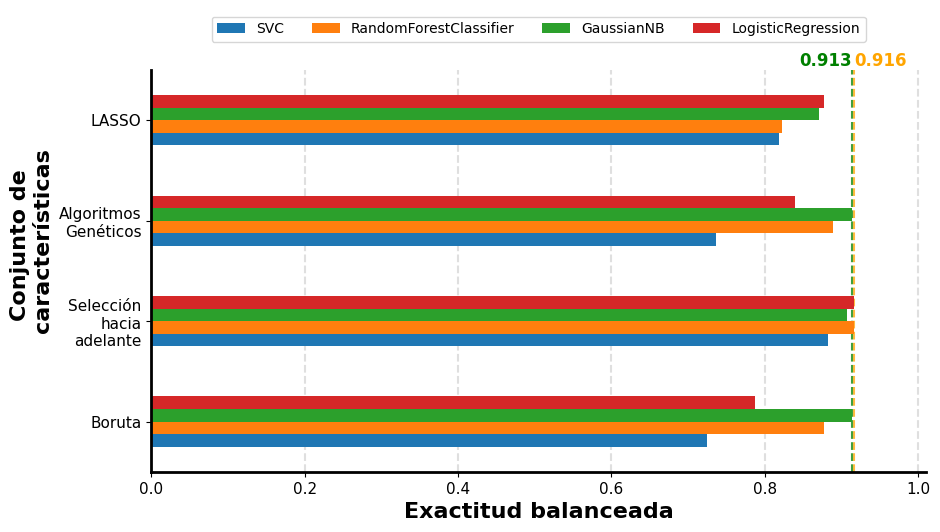

In [10]:
max_balanced_accuracy_RF = max(df_balanced_accuracies.T['RandomForestClassifier'])
max_balanced_accuracy_GNB = max(df_balanced_accuracies.T['GaussianNB'])
fig, ax = plt.subplots(figsize=(10, 6))
df_balanced_accuracies.T.plot.barh(ax=ax, zorder=3)

ax.set_xlim(0, 1.01)
ax.set_ylim(-0.5, 4.1)
ax.set_yticklabels(['Boruta', 'Selección\nhacia\nadelante', 
                    'Algoritmos\nGenéticos', 'LASSO'])
ax.legend(ncols=4, loc='upper center')
ax.tick_params(labelsize=11)

ax.set_xlabel('Exactitud balanceada', fontweight='bold', fontsize=16)
ax.set_ylabel('Conjunto de \ncaracterísticas', fontweight='bold', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set(lw=2, zorder=5)
ax.spines['left'].set(lw=2, zorder=5, bounds=(-0.5, 3.5))



ax.vlines(x=ax.get_xticks(), ymin=-0.5, ymax=3.5, color='gray', linestyle='--', 
          alpha=0.25)

ax.vlines(x=max_balanced_accuracy_RF, ymin=-0.5, ymax=3.5, 
          color='orange', alpha=0.75, linestyle='--')
ax.vlines(x=max_balanced_accuracy_GNB, ymin=-0.5, ymax=3.5, 
          color='green', alpha=0.75, linestyle='--')
ax.annotate(text=f'{max_balanced_accuracy_RF:0.3f}', xy=(max_balanced_accuracy_RF, 3.5), 
            va='bottom', ha='left', color='orange', fontweight='bold', fontsize=12)
ax.annotate(text=f'{max_balanced_accuracy_GNB:0.3f}', xy=(max_balanced_accuracy_GNB, 3.5), 
            va='bottom', ha='right', color='green', fontweight='bold', fontsize=12)

Text(0.9411764705882353, 3.5, '0.941')

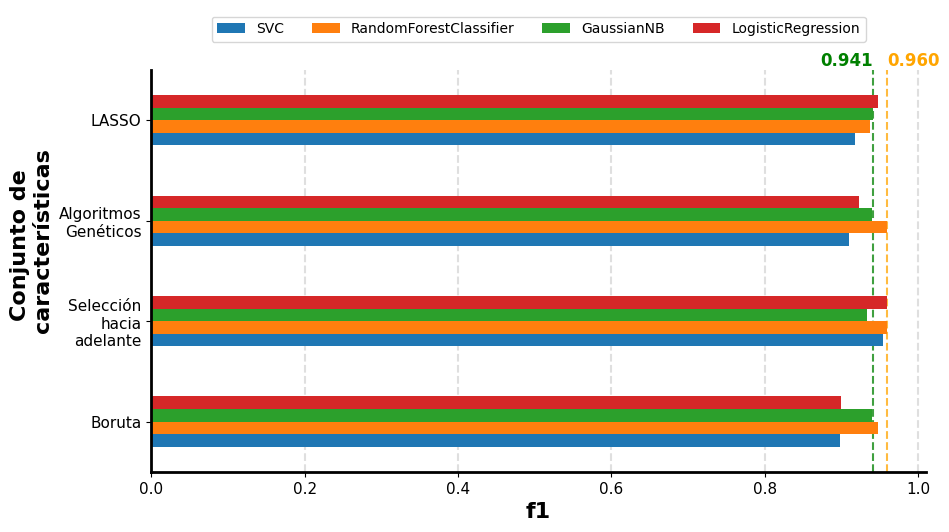

In [11]:
max_f1_RF = max(df_f1_scores.T['RandomForestClassifier'])
max_f1_GNB = max(df_f1_scores.T['GaussianNB'])
fig, ax = plt.subplots(figsize=(10, 6))
df_f1_scores.T.plot.barh(ax=ax, zorder=3)

ax.set_xlim(0, 1.01)
ax.set_ylim(-0.5, 4.1)
ax.set_yticklabels(['Boruta', 'Selección\nhacia\nadelante', 
                    'Algoritmos\nGenéticos', 'LASSO'])
ax.legend(ncols=4, loc='upper center')
ax.tick_params(labelsize=11)

ax.set_xlabel('f1', fontweight='bold', fontsize=16)
ax.set_ylabel('Conjunto de \ncaracterísticas', fontweight='bold', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set(lw=2, zorder=5)
ax.spines['left'].set(lw=2, zorder=5, bounds=(-0.5, 3.5))



ax.vlines(x=ax.get_xticks(), ymin=-0.5, ymax=3.5, color='gray', linestyle='--', 
          alpha=0.25)

ax.vlines(x=max_f1_RF, ymin=-0.5, ymax=3.5, 
          color='orange', alpha=0.75, linestyle='--')
ax.vlines(x=max_f1_GNB, ymin=-0.5, ymax=3.5, 
          color='green', alpha=0.75, linestyle='--')
ax.annotate(text=f'{max_f1_RF:0.3f}', xy=(max_f1_RF, 3.5), 
            va='bottom', ha='left', color='orange', fontweight='bold', fontsize=12)
ax.annotate(text=f'{max_f1_GNB:0.3f}', xy=(max_f1_GNB, 3.5), 
            va='bottom', ha='right', color='green', fontweight='bold', fontsize=12)

Text(0.9698823529411765, 3.5, '0.970')

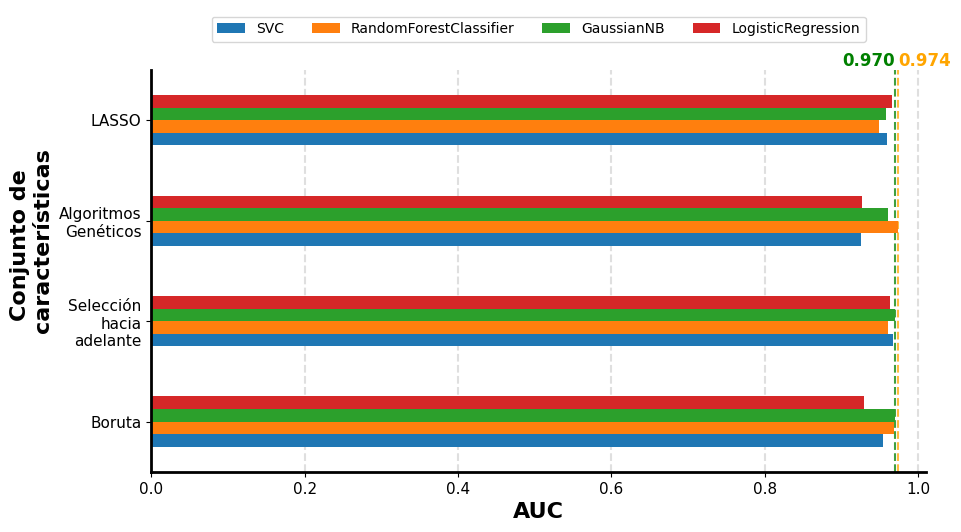

In [12]:
max_auc_RF = max(df_auc_scores.T['RandomForestClassifier'])
max_auc_GNB = max(df_auc_scores.T['GaussianNB'])
fig, ax = plt.subplots(figsize=(10, 6))
df_auc_scores.T.plot.barh(ax=ax, zorder=3)

ax.set_xlim(0, 1.01)
ax.set_ylim(-0.5, 4.1)
ax.set_yticklabels(['Boruta', 'Selección\nhacia\nadelante', 
                    'Algoritmos\nGenéticos', 'LASSO'])
ax.legend(ncols=4, loc='upper center')
ax.tick_params(labelsize=11)

ax.set_xlabel('AUC', fontweight='bold', fontsize=16)
ax.set_ylabel('Conjunto de \ncaracterísticas', fontweight='bold', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set(lw=2, zorder=5)
ax.spines['left'].set(lw=2, zorder=5, bounds=(-0.5, 3.5))



ax.vlines(x=ax.get_xticks(), ymin=-0.5, ymax=3.5, color='gray', linestyle='--', 
          alpha=0.25)

ax.vlines(x=max_auc_RF, ymin=-0.5, ymax=3.5, 
          color='orange', alpha=0.75, linestyle='--')
ax.vlines(x=max_auc_GNB, ymin=-0.5, ymax=3.5, 
          color='green', alpha=0.75, linestyle='--')
ax.annotate(text=f'{max_auc_RF:0.3f}', xy=(max_auc_RF, 3.5), 
            va='bottom', ha='left', color='orange', fontweight='bold', fontsize=12)
ax.annotate(text=f'{max_auc_GNB:0.3f}', xy=(max_auc_GNB, 3.5), 
            va='bottom', ha='right', color='green', fontweight='bold', fontsize=12)

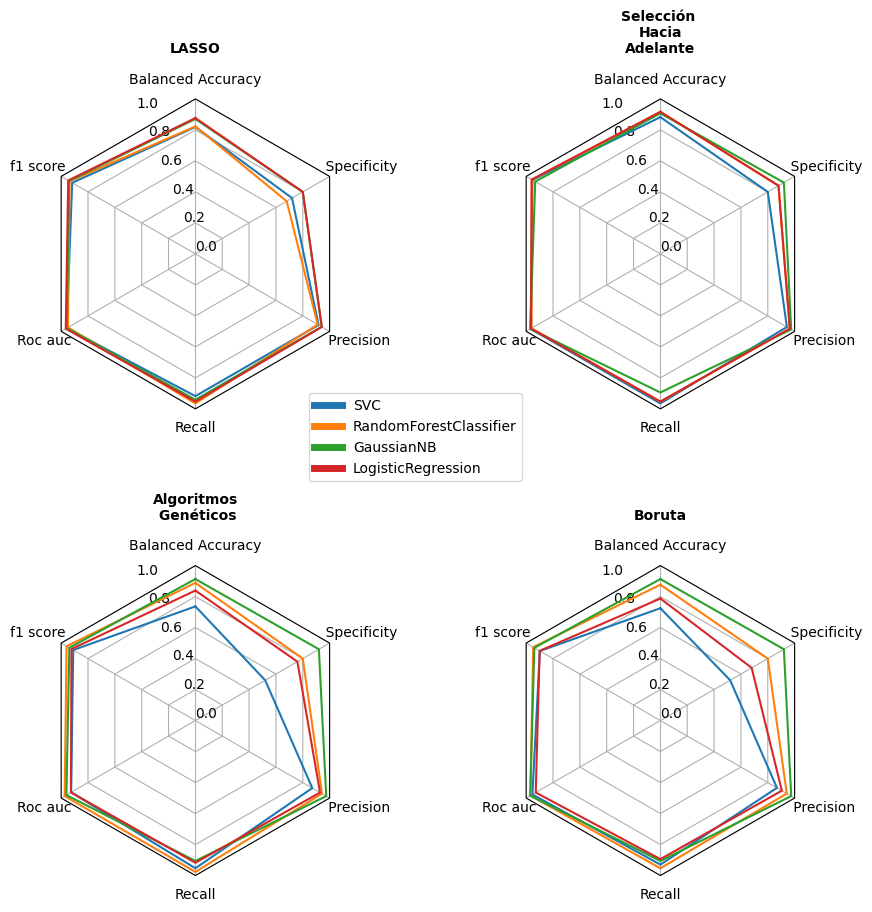

In [13]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='polygon'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


model_metrics = [balanced_accuracies, f1_scores, aucs, 
                 recalls, precisions, specificities]
data = [
        ['Balanced Accuracy','f1 score   ','Roc auc',
         'Recall', '      Precision', '       Specificity'],
        ('LASSO\n', [
            [m['lasso']['SVC'] for m in model_metrics], 
            [m['lasso']['RandomForestClassifier'] for m in model_metrics],
            [m['lasso']['GaussianNB'] for m in model_metrics],
            [m['lasso']['LogisticRegression'] for m in model_metrics]
        ]),
        ('Selección \nHacia\nAdelante\n', [
            [m['forward']['SVC'] for m in model_metrics], 
            [m['forward']['RandomForestClassifier'] for m in model_metrics],
            [m['forward']['GaussianNB'] for m in model_metrics],
            [m['forward']['LogisticRegression'] for m in model_metrics]
        ]),
        ('Algoritmos\n Genéticos\n', [
            [m['genetic']['SVC'] for m in model_metrics], 
            [m['genetic']['RandomForestClassifier'] for m in model_metrics],
            [m['genetic']['GaussianNB'] for m in model_metrics],
            [m['genetic']['LogisticRegression'] for m in model_metrics]
        ]),
        ('Boruta\n', [
            [m['boruta']['SVC'] for m in model_metrics], 
            [m['boruta']['RandomForestClassifier'] for m in model_metrics],
            [m['boruta']['GaussianNB'] for m in model_metrics],
            [m['boruta']['LogisticRegression'] for m in model_metrics]
        ]),
    ]

if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    ax_legend = fig.add_axes([0.2, 0.2, 0.6, 0.6])
    ax_legend.axis('off')
    ax_legend.plot([], [], label='SVC', color='C0', lw=5)
    ax_legend.plot([], [], label='RandomForestClassifier', color='C1', lw=5)
    ax_legend.plot([], [], label='GaussianNB', color='C2', lw=5)
    ax_legend.plot([], [], label='LogisticRegression', color='C3', lw=5)
    ax_legend.legend(loc='center', fontsize=10)
    
    fig.subplots_adjust(wspace=0.5, hspace=0.40, top=0.85, bottom=0.05)

    colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_ylim(0.5, 1)
        ax.set_rgrids([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
#            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('SVC', 'RandomForestClassifier', 'GaussianNB', 'LogisticRegression',)
    #legend = axs[1, 0].legend(labels, loc=(0.9, .95),
    #                          labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()